# Benchmark for CAG Phase classification

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from scipy.optimize import curve_fit

In [2]:
os.chdir("/pool01/projects/abante_lab/cag_propagation/scanvi_results")

## Supervised training

### Baseline

In [3]:
# Read metrics file
baseline_metrics = pd.read_csv("results_mn5/Baseline_supervised_metrics.tsv", sep='\t')
baseline_metrics.head()

,seed,dataset,n_hidden_layers,alpha,latent_dim,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test
0,1,v1_2k,2,10.0,60,0.560863,0.444905,0.521347,0.430045,0.305953,0.301814,0.274586,-0.019841
1,2,v1_2k,2,10.0,60,0.333333,0.333333,0.324462,0.324460,0.389934,0.407149,0.511878,0.062193
2,1,v1_2k,3,10.0,60,0.333333,0.333333,0.324462,0.324460,0.404206,0.455964,0.266923,-0.042390
3,2,v1_2k,3,10.0,60,0.333333,0.333333,0.324462,0.324460,0.365831,0.417302,0.481095,-0.016576
4,1,v1_2k,1,10.0,80,0.333333,0.333333,0.324462,0.324460,0.121184,0.127868,0.207270,0.153152


In [ ]:
baseline_metrics.iloc[baseline_metrics['balanced_accuracy_test'].idxmax()]

seed                              5
dataset                       v1_2k
n_hidden_layers                   1
alpha                          10.0
latent_dim                       20
balanced_accuracy_train    0.595686
balanced_accuracy_test     0.531924
f1_train                   0.367422
f1_test                    0.349875
ct_silhouette_train        0.062692
ct_silhouette_test          0.04029
y_silhouette_train         0.314475
y_silhouette_test           0.16606
Name: 544, dtype: object

In [6]:
# Average over seeds
avg_seed_baseline_metrics = (
    baseline_metrics.groupby(["dataset", "n_hidden_layers", "alpha", "latent_dim"], as_index=False)
      .mean(numeric_only=True)
)
avg_seed_baseline_metrics.head()

,dataset,n_hidden_layers,alpha,latent_dim,seed,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test
0,v1_2k,1,1.0,20,3.0,0.333333,0.333333,0.324462,0.324460,0.400208,0.402534,-0.085572,-0.116089
1,v1_2k,1,1.0,60,3.0,0.333333,0.333333,0.324462,0.324460,0.406071,0.392346,-0.067828,-0.115974
2,v1_2k,1,1.0,80,3.0,0.333333,0.333333,0.324462,0.324460,0.412667,0.418367,-0.105806,-0.142271
3,v1_2k,1,5.0,20,3.5,0.333333,0.333333,0.324462,0.324460,0.384198,0.378364,0.019665,-0.084993
4,v1_2k,1,5.0,60,3.0,0.389945,0.356771,0.368945,0.344337,0.421030,0.456251,0.001885,-0.107810


In [7]:
avg_seed_baseline_metrics.iloc[avg_seed_baseline_metrics['balanced_accuracy_test'].idxmax()]

dataset                       v2_2k
n_hidden_layers                   2
alpha                          10.0
latent_dim                       20
seed                            5.0
balanced_accuracy_train    0.627384
balanced_accuracy_test     0.481003
f1_train                   0.539066
f1_test                    0.443029
ct_silhouette_train        0.304104
ct_silhouette_test         0.338717
y_silhouette_train         0.299836
y_silhouette_test          -0.16058
Name: 90, dtype: object

In [ ]:
def plot_metric_vs_hyperparameters(
    df,
    metric='balanced_accuracy_test',
    hyperparams=None,
    aggfunc='mean',
    figsize=(8, 4)
):
    if hyperparams is None:
        hyperparams = [c for c in df.columns if c != metric]

    n_plots = len(hyperparams)
    n_cols = min(2, n_plots)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    axes = np.array(axes).flatten()

    for ax, hp in zip(axes, hyperparams):
        # Aggregate duplicates
        agg_df = df.groupby(hp)[metric].agg(aggfunc).reset_index()

        # Numeric → line plot
        if np.issubdtype(df[hp].dtype, np.number):
            sns.boxplot(x=hp, y=metric, data=agg_df, ax=ax)
        else:  # Categorical → bar plot
            sns.barplot(x=hp, y=metric, data=agg_df, ax=ax)
        
        ax.set_title(f"{metric} vs {hp}")
        ax.set_ylabel(metric)
        ax.set_xlabel(hp)
        ax.tick_params(axis='x', rotation=45)

    # Hide unused axes
    for ax in axes[n_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


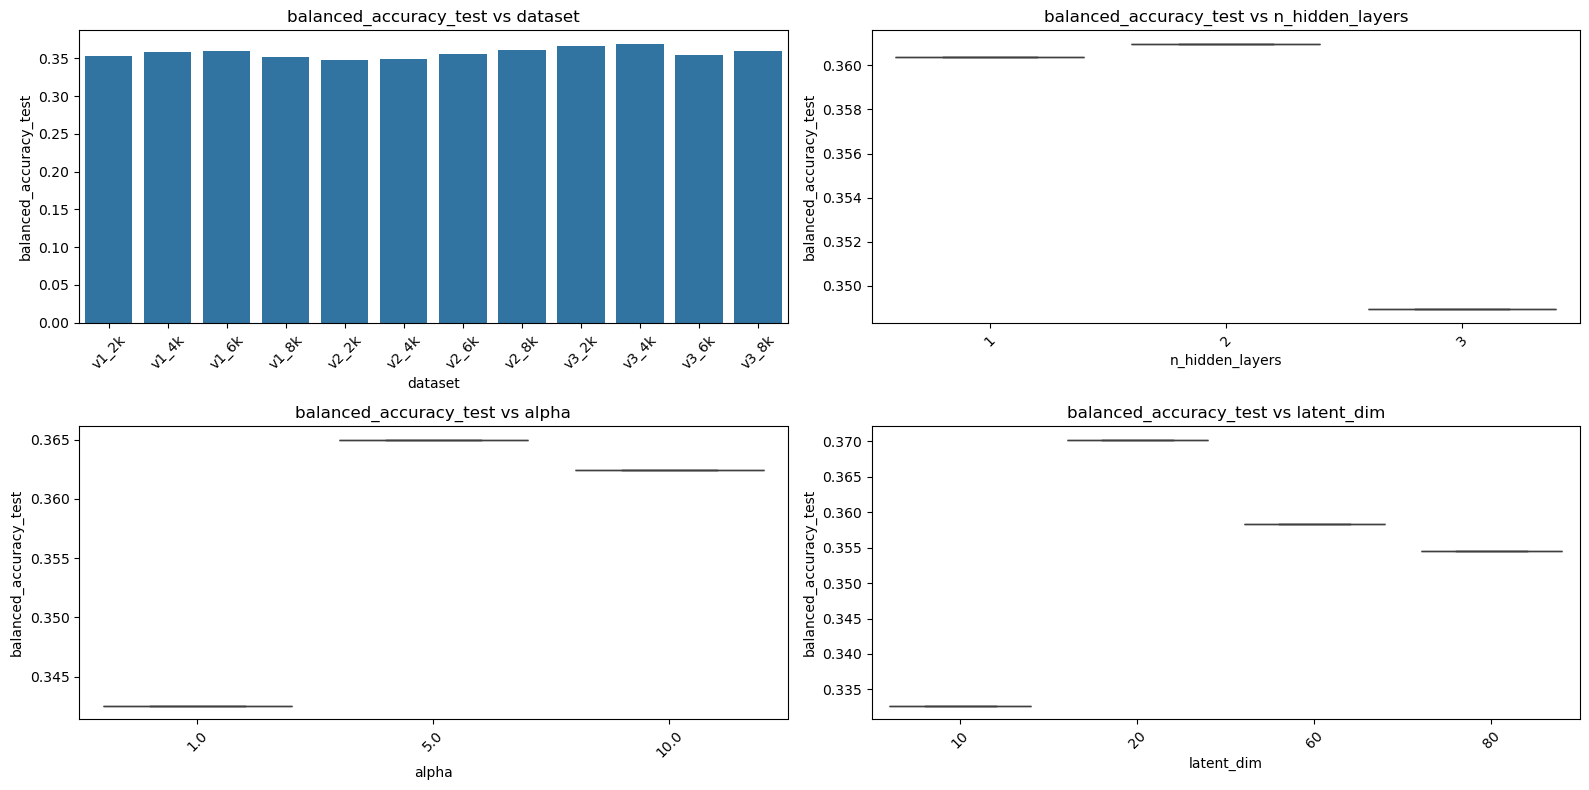

In [11]:
plot_metric_vs_hyperparameters(
    avg_seed_baseline_metrics,
    metric='balanced_accuracy_test',
    hyperparams=['dataset', 'n_hidden_layers', 'alpha', 'latent_dim']
)

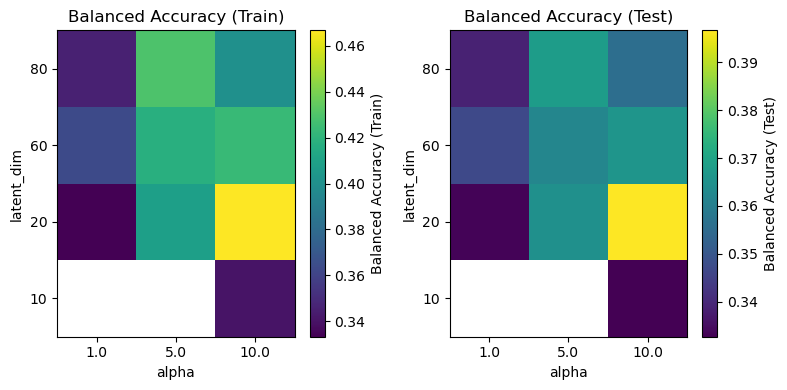

In [39]:
# Plot heatmap between balanced_accuracy_test, alpha, latent_dim
metrics_to_plot = [
    ('balanced_accuracy_train', 'Balanced Accuracy (Train)'),
    ('balanced_accuracy_test', 'Balanced Accuracy (Test)')
]

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()

for ax, (metric, title) in zip(axes, metrics_to_plot):
    pivot = avg_seed_baseline_metrics.pivot_table(index='latent_dim', columns='alpha', values=metric)
    im = ax.imshow(
        pivot.values, aspect='auto', cmap='viridis', origin='lower'
    )
    fig.colorbar(im, ax=ax, label=title)
    ax.set_xlabel('alpha')
    ax.set_ylabel('latent_dim')
    ax.set_title(title)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels([str(a) for a in pivot.columns])
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels([str(ld) for ld in pivot.index])

plt.tight_layout()
plt.show()

In [23]:
# For each dataset, save best BA in df
baseline_best_ba_per_dataset = avg_seed_baseline_metrics.loc[avg_seed_baseline_metrics.groupby('dataset')['balanced_accuracy_test'].idxmax()]
baseline_best_ba_per_dataset

,dataset,n_hidden_layers,alpha,latent_dim,seed,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test
6,v1_2k,1,10.0,20,3.50,0.464509,0.432629,0.345948,0.337167,0.204435,0.192465,0.270774,0.071728
25,v1_4k,1,5.0,20,3.00,0.487738,0.392535,0.436957,0.374627,0.393080,0.399096,0.182443,-0.017522
44,v1_6k,1,1.0,60,4.00,0.593288,0.442171,0.561026,0.444804,0.502129,0.514245,0.008698,-0.099235
71,v1_8k,2,5.0,80,2.50,0.553769,0.382075,0.508132,0.386755,0.411221,0.440015,0.328633,-0.078225
90,v2_2k,2,10.0,20,5.00,0.627384,0.481003,0.539066,0.443029,0.304104,0.338717,0.299836,-0.160580
112,v2_4k,2,10.0,80,2.00,0.482383,0.408170,0.430632,0.384216,0.261751,0.271716,0.268723,0.086955
123,v2_6k,1,10.0,60,3.25,0.485258,0.411276,0.455925,0.398112,0.352125,0.341917,0.150902,-0.015099
135,v2_8k,1,1.0,60,1.00,0.575747,0.466762,0.543387,0.461138,0.504494,0.516140,0.094076,-0.057587
171,v3_2k,3,5.0,80,3.00,0.504999,0.404473,0.459466,0.385299,0.345151,0.376563,0.155693,-0.016650
182,v3_4k,2,5.0,60,3.00,0.570998,0.426454,0.495350,0.403074,0.363252,0.393399,0.343723,-0.040592


### DCAG (ortho)

In [7]:
# Read metrics file
dcag_ortho_metrics = pd.read_csv("results_mn5/DCAG_ortho_supervised_metrics.tsv", sep='\t')
dcag_ortho_metrics.head()

,seed,dataset,n_hidden_layers,lamda_reg,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test
0,2,v3_2k,1,0.001,0.1,0.1,10,10,0.593245,0.552412,0.362992,0.357451,-0.092574,-0.089837,0.324806,0.223421
1,2,v1_2k,1,0.001,0.1,0.1,10,10,0.566554,0.543548,0.328200,0.322502,-0.012840,-0.002841,0.246920,0.174774
2,5,v1_2k,1,0.001,0.1,0.1,10,10,0.610324,0.550129,0.385186,0.377678,-0.052080,-0.048073,0.291208,0.187459
3,4,v3_2k,1,0.001,0.1,0.1,10,10,0.533847,0.528480,0.291115,0.290196,0.186488,0.195352,0.035937,0.041482
4,5,v1_4k,1,0.001,0.1,0.1,10,10,0.550015,0.536064,0.307154,0.308616,0.088786,0.079961,0.139002,0.103399


In [8]:
dcag_ortho_metrics.iloc[dcag_ortho_metrics['balanced_accuracy_test'].idxmax()]

seed                              3
dataset                       v2_6k
n_hidden_layers                   1
lamda_reg                     0.001
alpha_y                         0.1
alpha_ct                        0.1
latent_dim_y                     20
latent_dim_ct                    60
balanced_accuracy_train     0.76962
balanced_accuracy_test     0.710382
f1_train                   0.430109
f1_test                    0.405491
ct_silhouette_train        0.139786
ct_silhouette_test         0.156197
y_silhouette_train         0.123236
y_silhouette_test          0.084498
Name: 1035, dtype: object

In [9]:
# Average over seeds
avg_seed_dcag_ortho_metrics = (
    dcag_ortho_metrics.groupby(["dataset", "n_hidden_layers", "alpha_y","alpha_ct", "latent_dim_y", "latent_dim_ct", "lamda_reg"], as_index=False)
      .mean(numeric_only=True)
)
avg_seed_dcag_ortho_metrics.head()

,dataset,n_hidden_layers,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,lamda_reg,seed,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test
0,v1_2k,1,0.1,0.1,10,10,0.001,3.666667,0.575112,0.541859,0.339834,0.334512,0.040097,0.043963,0.214425,0.154291
1,v1_2k,1,0.1,0.1,10,10,0.010,3.500000,0.540009,0.524627,0.299595,0.296122,0.113449,0.118299,0.071786,0.040518
2,v1_2k,1,0.1,0.1,10,10,0.100,3.500000,0.571810,0.543473,0.336566,0.334379,0.080616,0.084269,0.192577,0.139183
3,v1_2k,1,0.1,0.1,10,10,1.000,3.333333,0.502834,0.502142,0.262534,0.261436,0.266033,0.276797,-0.104156,-0.117564
4,v1_2k,1,0.1,0.1,10,10,10.000,3.000000,0.506479,0.506015,0.268216,0.267504,0.323502,0.327633,-0.103911,-0.108377


In [10]:
avg_seed_dcag_ortho_metrics['alpha_y'].unique()

array([0.1])

In [11]:
avg_seed_dcag_ortho_metrics.iloc[avg_seed_dcag_ortho_metrics['balanced_accuracy_test'].idxmax()]

dataset                       v2_8k
n_hidden_layers                   1
alpha_y                         0.1
alpha_ct                        0.1
latent_dim_y                     20
latent_dim_ct                    80
lamda_reg                     0.001
seed                            1.0
balanced_accuracy_train     0.83858
balanced_accuracy_test     0.697737
f1_train                   0.474321
f1_test                    0.415338
ct_silhouette_train        0.083502
ct_silhouette_test         0.108835
y_silhouette_train         0.195153
y_silhouette_test          0.125743
Name: 466, dtype: object

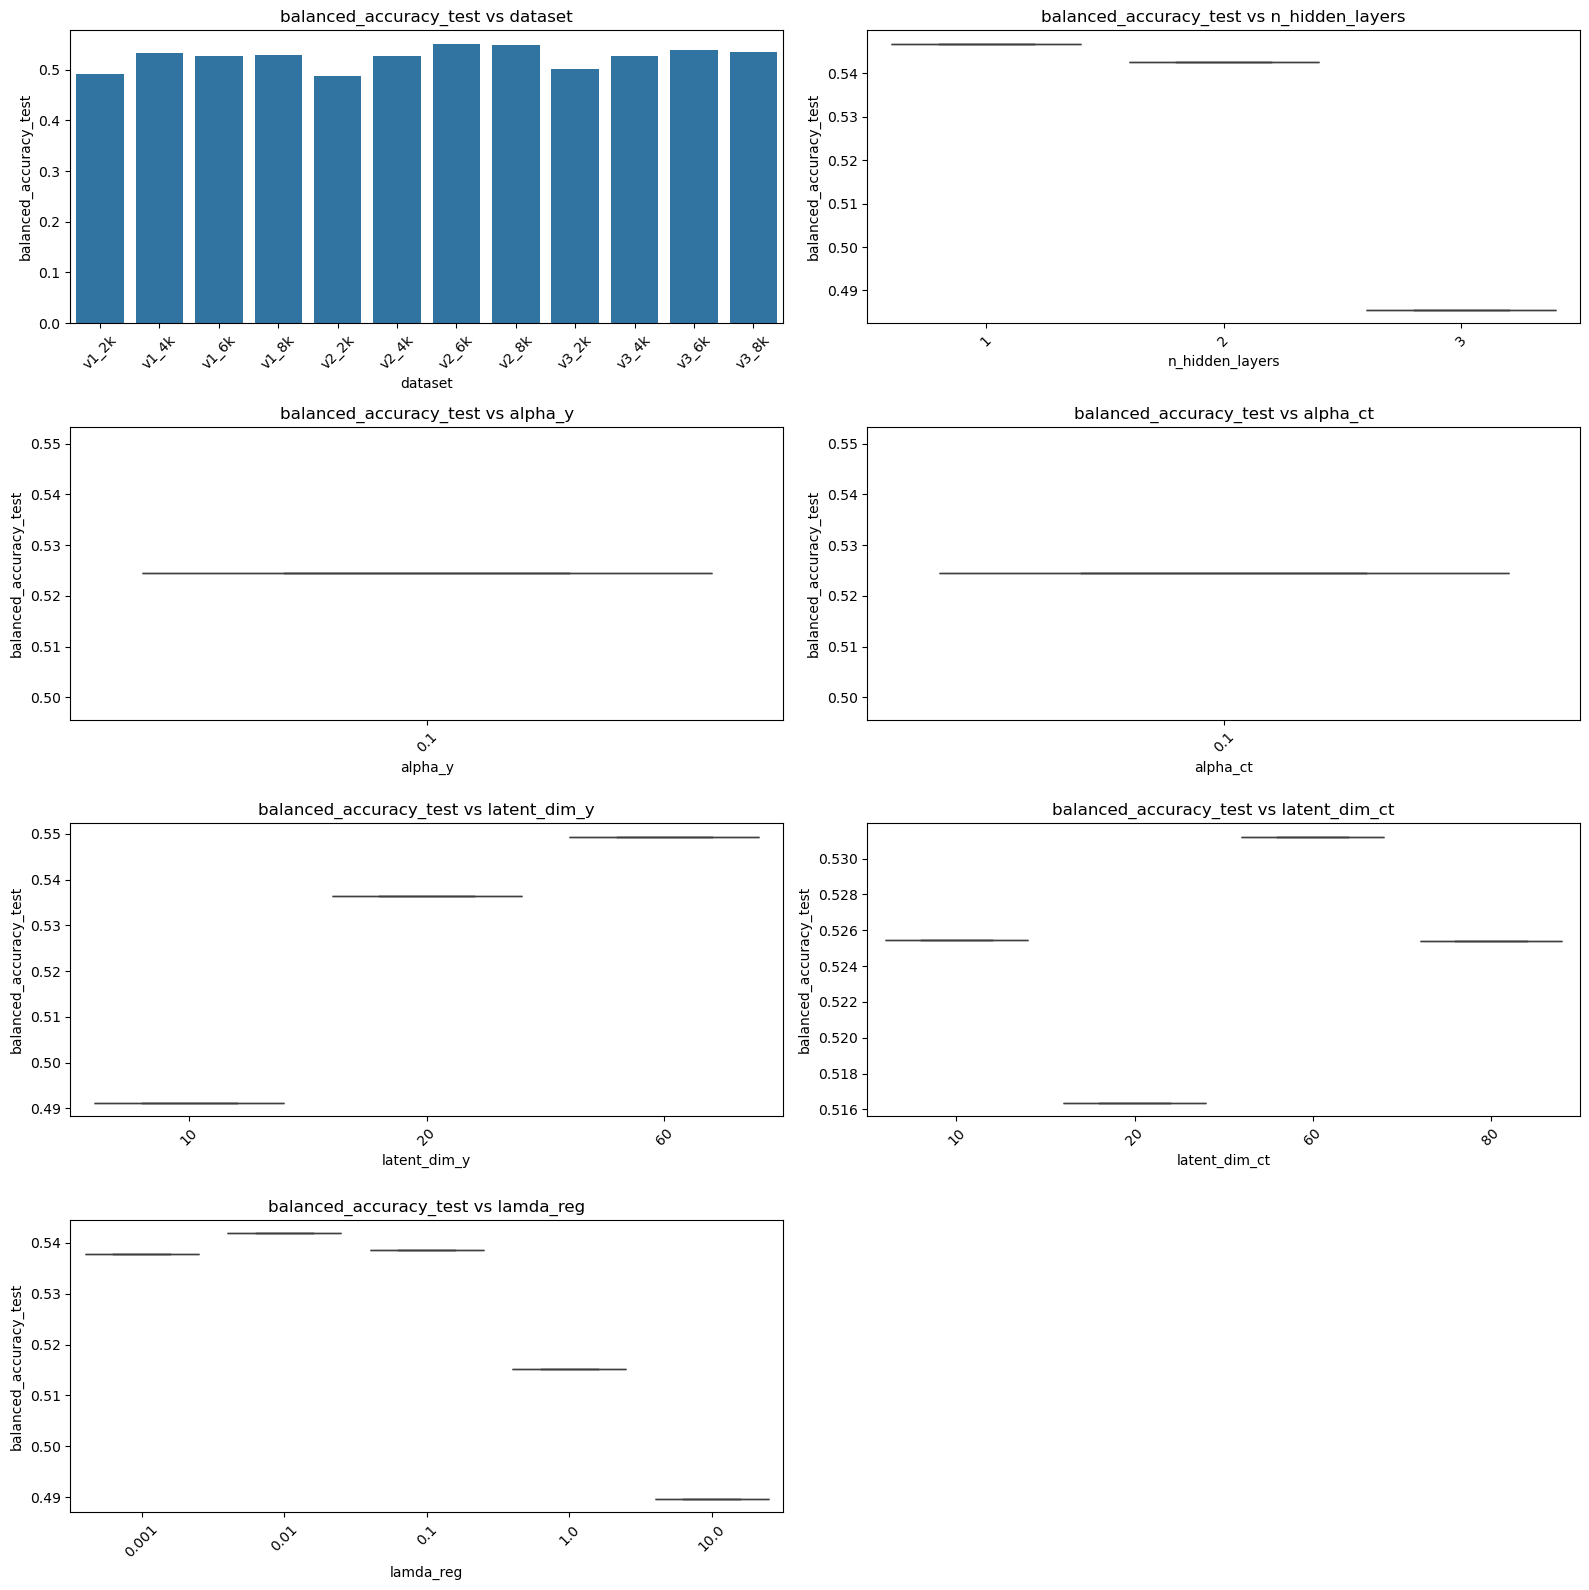

In [12]:
plot_metric_vs_hyperparameters(
    avg_seed_dcag_ortho_metrics,
    metric='balanced_accuracy_test',
    hyperparams=['dataset', 'n_hidden_layers', 'alpha_y', 'alpha_ct', 'latent_dim_y', 'latent_dim_ct', 'lamda_reg']
)

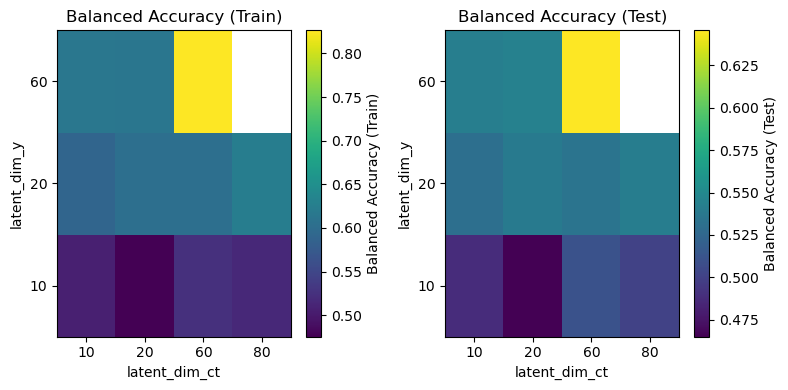

In [13]:
# Plot heatmap between balanced_accuracy_test, alpha, latent_dim
metrics_to_plot = [
    ('balanced_accuracy_train', 'Balanced Accuracy (Train)'),
    ('balanced_accuracy_test', 'Balanced Accuracy (Test)')
]

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()

for ax, (metric, title) in zip(axes, metrics_to_plot):
    pivot = avg_seed_dcag_ortho_metrics.pivot_table(index='latent_dim_y', columns='latent_dim_ct', values=metric)
    im = ax.imshow(
        pivot.values, aspect='auto', cmap='viridis', origin='lower'
    )
    fig.colorbar(im, ax=ax, label=title)
    ax.set_xlabel('latent_dim_ct')
    ax.set_ylabel('latent_dim_y')
    ax.set_title(title)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels([str(a) for a in pivot.columns])
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels([str(ld) for ld in pivot.index])

plt.tight_layout()
plt.show()

### DCAG (HSIC)

In [24]:
hsic_metrics= pd.read_csv("results_mn5/DCAG_hsic_supervised_metrics.tsv", sep='\t')
hsic_metrics.head()
hsic_metrics.iloc[hsic_metrics['balanced_accuracy_test'].idxmax()]

seed                                                                       3
dataset                                                                v2_6k
n_hidden_layers                                                            2
lamda_reg                                                              100.0
alpha_y                                                                  1.0
alpha_ct                                                                 0.1
latent_dim_y                                                              10
latent_dim_ct                                                             10
balanced_accuracy_train                                             0.845337
balanced_accuracy_test                                              0.710491
f1_train                                                            0.470019
f1_test                                                             0.416084
ct_silhouette_train                                                 0.048887

In [22]:
hsic_metrics_per_dataset = hsic_metrics.loc[hsic_metrics.groupby('dataset')['balanced_accuracy_test'].idxmax()]
hsic_metrics_per_dataset

,seed,dataset,n_hidden_layers,lamda_reg,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test,accuracy_ab_c_train,accuracy_ab_c_test,class_accuracies_train,class_accuracies_test
1009,3,v1_2k,2,1000.0,1.0,0.1,10,80,0.794918,0.683606,0.447494,0.406523,0.081848,0.097762,0.055769,0.060808,0.875947,0.777578,"{'A': 0.6550895587592835, 'B': 0.9191374663072...","{'A': 0.6438842373498361, 'B': 0.7905405405405..."
88,3,v1_4k,1,1000.0,1.0,0.1,10,10,0.849311,0.696315,0.484853,0.425210,0.040742,0.062734,-0.009674,0.074773,0.934401,0.783604,"{'A': 0.6888743264890054, 'B': 0.9380053908355...","{'A': 0.6788314524936294, 'B': 0.7871621621621..."
1130,5,v1_6k,3,100.0,1.0,0.1,10,80,0.845839,0.693618,0.514422,0.432660,0.123281,0.134174,-0.093911,0.026261,0.943574,0.751704,"{'A': 0.6513761467889908, 'B': 0.9703504043126...","{'A': 0.6512559155442301, 'B': 0.8918918918918..."
499,2,v1_8k,2,100.0,1.0,0.1,10,20,0.797573,0.701548,0.495220,0.443171,0.103337,0.110713,-0.015117,0.007235,0.883969,0.772263,"{'A': 0.6438036988495704, 'B': 0.9541778975741...","{'A': 0.6356024754277394, 'B': 0.8952702702702..."
435,5,v2_2k,3,100.0,1.0,0.1,10,20,0.829418,0.698703,0.451133,0.406941,-0.007175,-0.013066,0.043811,0.076784,0.902342,0.784933,"{'A': 0.6521770787825834, 'B': 0.9676549865229...","{'A': 0.6527120495085548, 'B': 0.8040540540540..."
217,3,v2_4k,3,100.0,1.0,0.1,10,10,0.769567,0.709658,0.440968,0.413545,0.026875,0.048881,0.075325,0.059589,0.905116,0.817277,"{'A': 0.6479539828163682, 'B': 0.7870619946091...","{'A': 0.6366945759009829, 'B': 0.7939189189189..."
121,3,v2_6k,2,100.0,1.0,0.1,10,10,0.845337,0.710491,0.470019,0.416084,0.048887,0.053302,0.107705,0.101056,0.944435,0.821442,"{'A': 0.6559633027522935, 'B': 0.9353099730458...","{'A': 0.6462504550418638, 'B': 0.7770270270270..."
239,1,v2_8k,1,100.0,1.0,0.1,10,10,0.877688,0.694649,0.545373,0.458396,0.033102,0.008087,-0.031646,0.044359,0.975290,0.786086,"{'A': 0.6890927624872579, 'B': 0.9676549865229...","{'A': 0.6867491809246451, 'B': 0.7939189189189..."
304,5,v3_2k,1,100.0,1.0,0.1,10,20,0.803054,0.692515,0.444150,0.404470,0.149164,0.148044,0.037404,0.048291,0.914969,0.779926,"{'A': 0.6411096548711228, 'B': 0.8733153638814...","{'A': 0.6438842373498361, 'B': 0.8074324324324..."
249,1,v3_4k,2,1000.0,1.0,0.1,10,10,0.830941,0.706495,0.468628,0.422353,0.060409,0.066835,-0.200819,-0.020862,0.927002,0.792820,"{'A': 0.6495558468035533, 'B': 0.9380053908355...","{'A': 0.6524390243902439, 'B': 0.8277027027027..."


In [25]:
# Average over seeds
avg_seed_dcag_hsic_metrics = (
    hsic_metrics.groupby(["dataset", "n_hidden_layers", "alpha_y","alpha_ct", "latent_dim_y", "latent_dim_ct", "lamda_reg"], as_index=False)
      .mean(numeric_only=True)
)
avg_seed_dcag_hsic_metrics.head()

,dataset,n_hidden_layers,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,lamda_reg,seed,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test,accuracy_ab_c_train,accuracy_ab_c_test
0,v1_2k,1,1.0,0.1,10,10,100.0,3.0,0.743251,0.563345,0.442358,0.363202,-0.005395,-0.006594,0.183569,0.116696,0.824824,0.709680
1,v1_2k,1,1.0,0.1,10,10,1000.0,3.0,0.543426,0.530382,0.292236,0.289091,0.258857,0.262664,-0.021599,-0.025005,0.717693,0.713473
2,v1_2k,1,1.0,0.1,10,20,100.0,3.0,0.829471,0.567985,0.504879,0.385456,-0.056440,-0.051750,0.258438,0.155751,0.912220,0.747756
3,v1_2k,1,1.0,0.1,10,20,1000.0,3.0,0.727085,0.601164,0.395944,0.355575,0.098211,0.094352,0.077243,0.080480,0.868865,0.759788
4,v1_2k,1,1.0,0.1,10,60,100.0,3.0,0.854799,0.548640,0.547514,0.404423,-0.051082,-0.048556,0.315462,0.191548,0.928340,0.722351


In [ ]:
plot_metric_vs_hyperparameters(
    avg_seed_dcag_ortho_metrics,
    metric='balanced_accuracy_test',
    hyperparams=['dataset', 'n_hidden_layers', 'alpha_y', 'alpha_ct', 'latent_dim_y', 'latent_dim_ct', 'lamda_reg']
)

### SCANVI (from package)

In [ ]:
# Read metrics file
SCANVI_metrics = pd.read_csv("SCANVI_supervised_metrics.tsv", sep='\t')
SCANVI_metrics.head()
SCANVI_metrics.iloc[SCANVI_metrics['balanced_accuracy_test'].idxmax()]

seed                                                                        1
dataset                                                                 v2_6k
n_hidden_layers                                                             2
latent_dim                                                                 20
unseen_y_prop                                                             0.0
balanced_accuracy_train                                              0.895623
balanced_accuracy_test                                               0.645222
f1_train                                                              0.51416
f1_test                                                               0.41452
ct_silhouette_train                                                  0.406891
ct_silhouette_test                                                   0.437481
y_silhouette_train                                                  -0.128893
y_silhouette_test                                               

## Masking benchmark

### DCAG

In [4]:
# dcag_ortho_metrics_masked = pd.read_csv("DCAG_ortho_supervised_metrics.tsv", sep='\t', index_col=False)
dcag_ortho_metrics_masked = pd.read_csv("results_mn5/DCAG_ortho_xalpha_supervised_metrics_2.tsv", sep='\t', index_col=False)
dcag_ortho_metrics_masked.head(2)

,seed,dataset,n_hidden_layers,lamda_reg,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,unseen_y_prop,balanced_accuracy_train,...,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test,accuracy_ab_c_train,accuracy_ab_c_test,class_accuracies_train,class_accuracies_test,balanced_accuracy_masked
0,1,v2_6k,2,0.001,7.0,0.1,20,20,0.0,0.784439,...,0.372937,0.338412,0.311235,-0.141308,-0.101765,0.894725,0.810231,"{'A': 0.5631280034949759, 'B': 0.9191374663072...","{'A': 0.5695303967965053, 'B': 0.7263513513513...",NaN
1,3,v2_6k,2,0.001,5.0,0.1,20,20,0.0,0.723445,...,0.349346,0.373310,0.375648,-0.123570,-0.140057,0.831355,0.770311,"{'A': 0.5441968836464249, 'B': 0.8814016172506...","{'A': 0.53394612304332, 'B': 0.783783783783783...",NaN


In [5]:
alfes = [0.01, 0.1, 1.0, 2.0, 5.0, 7.0, 10.0, 13.0]
dcag_ortho_metrics_masked = dcag_ortho_metrics_masked[dcag_ortho_metrics_masked['alpha_y'].isin(alfes)]
dcag_ortho_metrics_masked['alpha_y'].unique()

array([ 7.  ,  5.  ,  2.  ,  1.  ,  0.01, 10.  ,  0.1 ])

In [8]:
metrics = ['balanced_accuracy_train', 'balanced_accuracy_test', 'f1_train',
       'f1_test', 'ct_silhouette_train', 'ct_silhouette_test',
       'y_silhouette_train', 'y_silhouette_test', 'accuracy_ab_c_train',
       'accuracy_ab_c_test', 'balanced_accuracy_masked']
stats = (
    dcag_ortho_metrics_masked
    .groupby(
        ["n_hidden_layers", "alpha_y", "alpha_ct",
         "latent_dim_y", "latent_dim_ct", "lamda_reg", "unseen_y_prop"]
    )[metrics]
    .agg(['mean', 'std'])
)
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = stats.reset_index()

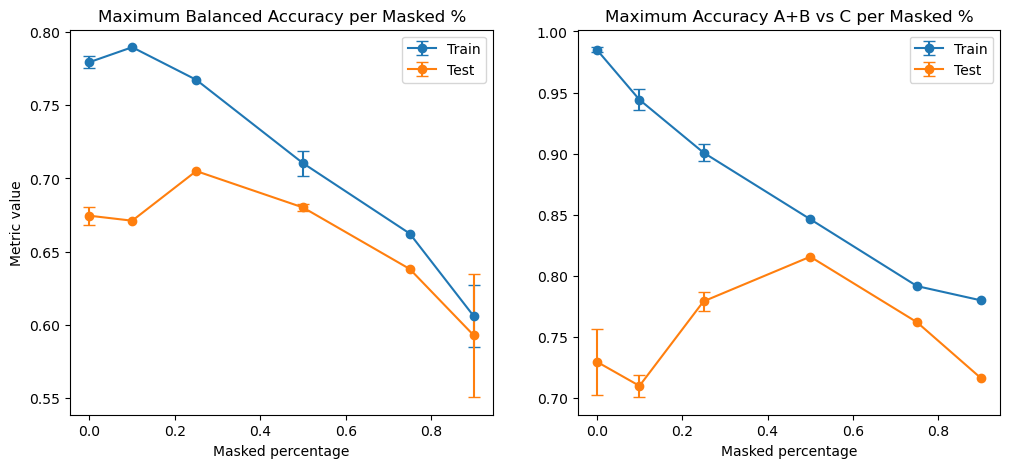

In [60]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)

idx = stats.groupby('unseen_y_prop')['balanced_accuracy_test_mean'].idxmax()
best = stats.loc[idx].sort_values("unseen_y_prop")
plt.errorbar(
    best['unseen_y_prop'], best['balanced_accuracy_train_mean'],
    yerr=best['balanced_accuracy_train_std'],
    label='Train', marker='o', capsize=4
)

plt.errorbar(
    best['unseen_y_prop'], best['balanced_accuracy_test_mean'],
    yerr=best['balanced_accuracy_test_std'],
    label='Test', marker='o', capsize=4
)

plt.title('Maximum Balanced Accuracy per Masked %')
plt.xlabel('Masked percentage')
plt.ylabel('Metric value')
plt.legend()

plt.subplot(1,2,2)

idx = stats.groupby('unseen_y_prop')['accuracy_ab_c_train_mean'].idxmax()
best = stats.loc[idx].sort_values("unseen_y_prop")
plt.errorbar(
    best['unseen_y_prop'], best['accuracy_ab_c_train_mean'],
    yerr=best['accuracy_ab_c_train_std'],
    label='Train', marker='o', capsize=4
)

plt.errorbar(
    best['unseen_y_prop'], best['accuracy_ab_c_test_mean'],
    yerr=best['accuracy_ab_c_test_std'],
    label='Test', marker='o', capsize=4
)

plt.title('Maximum Accuracy A+B vs C per Masked %')
plt.xlabel('Masked percentage')
plt.legend()
plt.show()

In [9]:
best_values = dcag_ortho_metrics_masked.groupby('unseen_y_prop')['balanced_accuracy_test'].max()
best_values

unseen_y_prop
0.00    0.708306
0.10    0.708650
0.25    0.719335
0.50    0.718659
0.75    0.665264
0.90    0.651683
Name: balanced_accuracy_test, dtype: float64

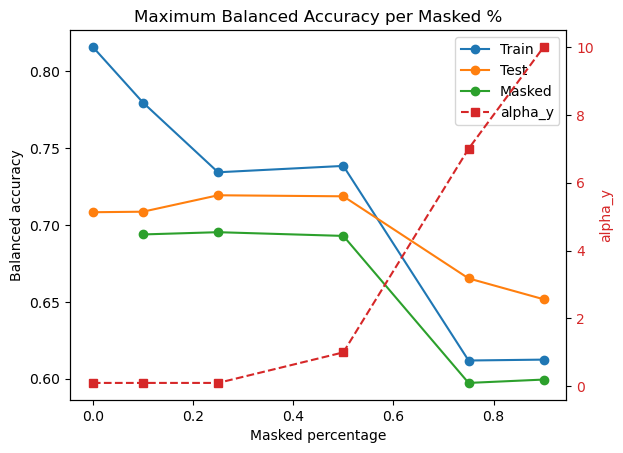

In [13]:
# For each unseen_y_prop, get the row with the maximum test balanced accuracy
idx = dcag_ortho_metrics_masked.groupby('unseen_y_prop')['balanced_accuracy_test'].idxmax()
best_rows = dcag_ortho_metrics_masked.loc[idx].sort_values('unseen_y_prop')

# Plot Train/Test balanced accuracy
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_train'], label='Train', marker='o')
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_test'], label='Test', marker='o')
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_masked'], label='Masked', marker='o')

# Create secondary y-axis for alpha_y
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(best_rows['unseen_y_prop'], best_rows['alpha_y'], color='tab:red', marker='s', linestyle='--', label='alpha_y')
ax2.set_ylabel('alpha_y', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles and labels
ax1.set_title('Maximum Balanced Accuracy per Masked %')
ax1.set_xlabel('Masked percentage')
ax1.set_ylabel('Balanced accuracy')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.savefig("/pool01/projects/abante_lab/cag_propagation/presentation_figures/masked_alpha.svg")

plt.show()

In [74]:
data_reg = best_rows[['unseen_y_prop', 'alpha_y']]


In [106]:
data_reg

,unseen_y_prop,alpha_y
312,0.00,0.1
8734,0.10,0.1
6848,0.25,0.1
5728,0.50,1.0
6106,0.75,7.0
10910,0.90,10.0


In [107]:
# Fit quadratic function to alpha values
fit = np.polyfit(data_reg['unseen_y_prop'], data_reg['alpha_y'], 2)
equation = np.poly1d(fit)
print("The fit coefficients are a = {0:.4f}, b = {1:.4f} c = {2:.4f}".format(*fit))
print(equation)

The fit coefficients are a = 20.5209, b = -7.4546 c = 0.3590
       2
20.52 x - 7.455 x + 0.359


In [3]:
def alpha_scal(unseen_y_prop):
    return 20.5209*unseen_y_prop**2 - 7.4546*unseen_y_prop + 0.359

In [109]:
alpha_scal(best_rows['unseen_y_prop'])

312       0.359000
8734     -0.181251
6848     -0.222094
5728      1.761925
6106      6.311056
10910    10.271789
Name: unseen_y_prop, dtype: float64

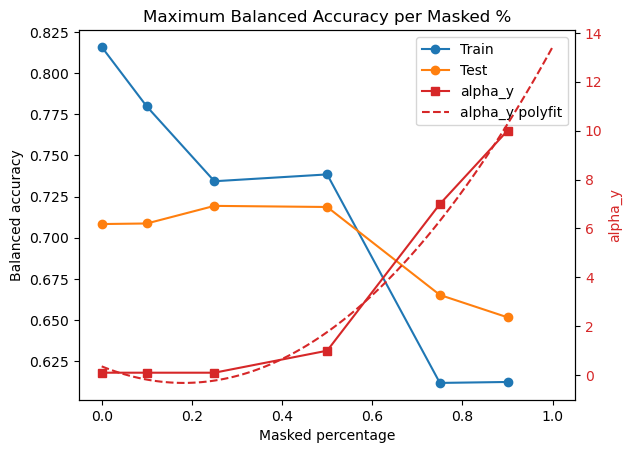

In [8]:
# For each unseen_y_prop, get the row with the maximum test balanced accuracy
idx = dcag_ortho_metrics_masked.groupby('unseen_y_prop')['balanced_accuracy_test'].idxmax()
best_rows = dcag_ortho_metrics_masked.loc[idx].sort_values('unseen_y_prop')

# Plot Train/Test balanced accuracy
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_train'], label='Train', marker='o')
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_test'], label='Test', marker='o')

# Create secondary y-axis for alpha_y
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(best_rows['unseen_y_prop'], best_rows['alpha_y'], color='tab:red', marker='s', linestyle='-', label='alpha_y')
ax2.set_ylabel('alpha_y', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

masked_percentages = np.linspace(0, 1, 100)
ax2.plot(masked_percentages, alpha_scal(masked_percentages), color='tab:red', linestyle='--', label='alpha_y polyfit')

# Titles and labels
ax1.set_title('Maximum Balanced Accuracy per Masked %')
ax1.set_xlabel('Masked percentage')
ax1.set_ylabel('Balanced accuracy')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.savefig("/pool01/projects/abante_lab/cag_propagation/presentation_figures/masked_alpha.svg")

plt.show()

In [ ]:
x = np.array([0.00, 0.10, 0.25, 0.50, 0.75, 0.90])
y = np.array([0.1, 0.1, 0.1, 1.0, 7.0, 10.0])

# Exponential function
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit
popt, _ = curve_fit(exp_func, x, y, p0=(1, 1, 0))  # initial guess

# Evaluate
y_fit = exp_func(x, *popt)

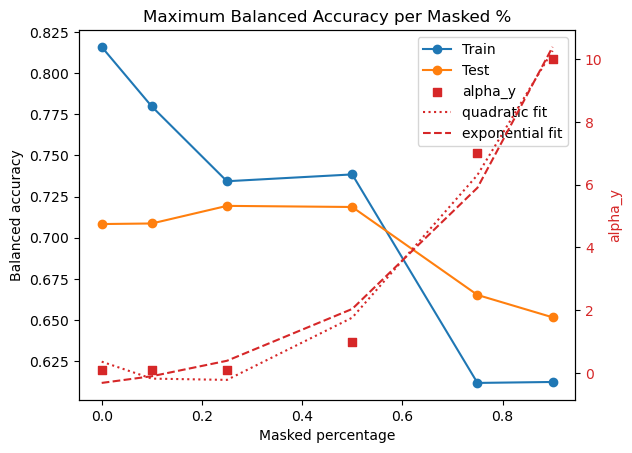

In [118]:
# Plot Train/Test balanced accuracy
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_train'], label='Train', marker='o')
plt.plot(best_rows['unseen_y_prop'], best_rows['balanced_accuracy_test'], label='Test', marker='o')

# Create secondary y-axis for alpha_y
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.scatter(best_rows['unseen_y_prop'], best_rows['alpha_y'], color='tab:red', marker='s', label='alpha_y')
ax2.plot(best_rows['unseen_y_prop'], alpha_scal(best_rows['unseen_y_prop']), color='tab:red', linestyle=':', label='quadratic fit')
ax2.plot(best_rows['unseen_y_prop'], y_fit, color='tab:red', linestyle='--', label='exponential fit')
ax2.set_ylabel('alpha_y', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles and labels
ax1.set_title('Maximum Balanced Accuracy per Masked %')
ax1.set_xlabel('Masked percentage')
ax1.set_ylabel('Balanced accuracy')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()

### scANVI

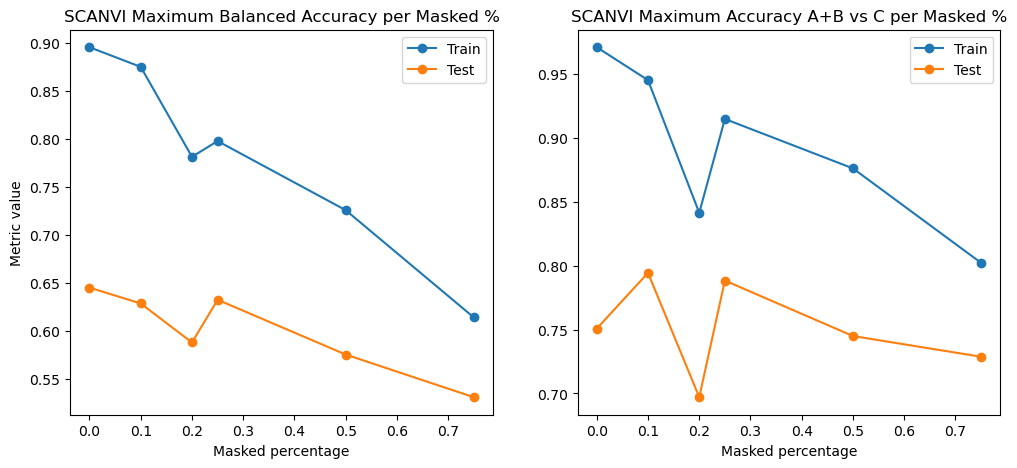

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)

idx = SCANVI_metrics.groupby('unseen_y_prop')['balanced_accuracy_test'].idxmax()
best_values = SCANVI_metrics.loc[idx].sort_values('unseen_y_prop')
plt.plot(best_values['unseen_y_prop'], best_values['balanced_accuracy_train'], label='Train', marker='o')
plt.plot(best_values['unseen_y_prop'], best_values['balanced_accuracy_test'], label='Test', marker='o')

plt.title('SCANVI Maximum Balanced Accuracy per Masked %')
plt.xlabel('Masked percentage')
plt.ylabel('Metric value')
plt.legend()

plt.subplot(1,2,2)

idx = SCANVI_metrics.groupby('unseen_y_prop')['accuracy_ab_c_train'].idxmax()
best_values = SCANVI_metrics.loc[idx].sort_values('unseen_y_prop')
plt.plot(best_values['unseen_y_prop'], best_values['accuracy_ab_c_train'], label='Train', marker='o')
plt.plot(best_values['unseen_y_prop'], best_values['accuracy_ab_c_test'], label='Test', marker='o')

plt.title('SCANVI Maximum Accuracy A+B vs C per Masked %')
plt.xlabel('Masked percentage')
plt.legend()

plt.show()

## Semi-supervised ortho DCAG with scaled alpha

In [7]:
dcag_ortho_metrics_multitech = pd.read_csv("results_mn5/all_mn5_29nov/DCAG_ortho_semisupervised_metrics.tsv", sep='\t', index_col=False)
dcag_ortho_metrics_multitech.head(2)

,seed,dataset,n_hidden_layers,lamda_reg,alpha_y,alpha_ct,latent_dim_y,latent_dim_ct,unseen_y_prop,balanced_accuracy_train,...,f1_test,ct_silhouette_train,ct_silhouette_test,y_silhouette_train,y_silhouette_test,accuracy_ab_c_train,accuracy_ab_c_test,class_accuracies_train,class_accuracies_test,balanced_accuracy_masked
0,1,deep_dive_10x_v1_6k_test0.5_adata,2,0.010,1.759445,0.1,20,20,0.0,0.973887,...,0.458498,-0.318681,-0.319890,0.775310,0.414535,0.978695,0.672396,"{'A': 0.9506729719898145, 'B': 0.9973045822102...","{'A': 0.9221878412813979, 'B': 0.1993243243243...",NaN
1,1,deep_dive_10x_v1_6k_test0.5_adata,1,0.001,1.759445,0.1,10,10,0.0,0.549635,...,0.313767,-0.062349,0.105897,0.268953,0.037538,0.813260,0.785894,"{'A': 0.6457620953073845, 'B': 0.0215633423180...","{'A': 0.6374226428831452, 'B': 0.0337837837837...",NaN


In [8]:
dcag_ortho_metrics_multitech.iloc[dcag_ortho_metrics_multitech['balanced_accuracy_test'].idxmax()]

seed                                                                        3
dataset                                     deep_dive_10x_v1_6k_test0.5_adata
n_hidden_layers                                                             1
lamda_reg                                                               0.001
alpha_y                                                              1.759445
alpha_ct                                                                  1.0
latent_dim_y                                                               10
latent_dim_ct                                                              80
unseen_y_prop                                                             0.0
balanced_accuracy_train                                              0.779384
balanced_accuracy_test                                               0.667993
f1_train                                                              0.40472
f1_test                                                         

In [3]:
SCANVI_metrics = pd.read_csv("SCANVI_semisupervised_multitech_metrics.tsv", sep='\t')
SCANVI_metrics.head()
SCANVI_metrics.iloc[SCANVI_metrics['balanced_accuracy_test'].idxmax()]

seed                                                                        2
dataset                                     deep_dive_10x_v1_6k_test0.5_adata
n_hidden_layers                                                             2
latent_dim                                                                 20
unseen_y_prop                                                             0.0
balanced_accuracy_train                                               0.66876
balanced_accuracy_test                                               0.612022
f1_train                                                             0.269711
f1_test                                                              0.430155
ct_silhouette_train                                                  0.301711
ct_silhouette_test                                                   0.270156
y_silhouette_train                                                  -0.136076
y_silhouette_test                                               